# A tutorial to perform a cosmological analysis with BORG

## Introduction

For this tutorial, we will assume that you properly built BORG from source. We will consider that `ARES_SOURCE_PATH` points to the root of the ARES git that obtained by cloning from https://bitbucket.org/bayesian_lss_team/ares.git. `$ARES_BUILD_PATH` will be the build directory. If you executed `build.sh` without argument it will be located in `$ARES_SOURCE_PATH/build/`.

After that we create a directory in `CHAIN_DIR` (which is to your convenience). For the purpose of this tutotrial, we will have the directory in your home folder in `borg_test_chain`.

The first step is copying the example files in place:
```bash
mkdir $CHAIN_DIR
cd $CHAIN_DIR
# The BORG configuration file
cp $ARES_SOURCE_PATH/examples/2mpp-chain.ini.txt .
# Some data (actually not used but it is required to be there)
cp $ARES_SOURCE_PATH/examples/2MPP.txt .
# Mask/selection describing the data
cp $ARES_SOURCE_PATH/examples/completeness_* .
```

In [1]:
%%bash
CHAIN_DIR=$HOME/borg_test_chain
ARES_SOURCE_PATH=$HOME/PROJECTS/ares_clean
ARES_BUILD_PATH=$ARES_SOURCE_PATH/build
cd $CHAIN_DIR
rm -f $CHAIN_DIR/mcmc_*
rm -f $CHAIN_DIR/restart.h5_0
cp $ARES_SOURCE_PATH/examples/2mpp-chain.ini.txt .
cp $ARES_SOURCE_PATH/examples/2MPP.txt .
cp $ARES_SOURCE_PATH/examples/completeness_* .

The second step is to actually run BORG on the example configuration. We do it as follow
```bash
# Be sure to be in the chain directory
cd $CHAIN_DIR
# Run hades with INIT (to indicate you want to start from scratch) and the configuration file
$ARES_BUILD_PATH/src/hades3 INIT 2mpp-chain.ini.txt
```
The code will run for some time. It is set to generate 1000 MCMC files before exiting cleanly. If you want to reduce that number for testing purpose on your laptop, it is possible by changing the configuration `number_to_generate` in `2mpp-chain.ini.txt`.

In [2]:
%%bash
CHAIN_DIR=$HOME/borg_test_chain
ARES_SOURCE_PATH=$HOME/PROJECTS/ares_clean
ARES_BUILD_PATH=$ARES_SOURCE_PATH/build
cd $CHAIN_DIR
$ARES_BUILD_PATH/src/hades3 INIT 2mpp-chain.ini.txt > /dev/null

[  0/  1] [WARNING] | | No [likelihood] section in params tree
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I used a default weight of 1
[  0/  1] [WARNING] | | I will pick default bias parameters as the present array is too s

This should take about 20 mins on a 20-40 cores workstation. The 1000 MCMC files requires about 1 GB on hard drive. The default setup also has a short log of the actions taken by the code in the file `logares.txt_rank_0` . The log can be increased or reduced by setting `logfile_verbose_level` to a different number, though for debugging purpose in case of error, it is advised to put it back to debug level (level 5) and it is good practice to keep it above 3. You should now see a content like here below:

In [3]:
!ls $HOME/borg_test_chain | tail -n 10

mcmc_995.h5
mcmc_996.h5
mcmc_997.h5
mcmc_998.h5
mcmc_999.h5
mcmc_99.h5
mcmc_9.h5
mock_data.h5
restart.h5_0
timing_stats_0.txt


 

Now we will look at the out puts generated by the BORG run. Note, that you do not have to wait for the run to complete, but you can already investigate intermediate results while BORG still runs. BORG results are stored in two major HDF5 files, the restart and the mcmc files. The restart files contain all information on the state of the Markov Chain required to resume the Markov Chain if it has been interrupted. The restart file also contains static information, that will not change during the run, such as the data, selection functions and masks and other settings. The mcmc files contain the current state of the Markov Chain. They are indexed by the current step in the chain, and contain the current sampled values of density fields, power-spectra, galaxy bias and cosmological parameters etc.

## The required python preamble

The basic analysis tools are bundled in a python package called pyaquila (https://bitbucket.org/bayesian_lss_team/pyaquila.git). You may install it with:

In [4]:
!pip install git+https://bitbucket.org/bayesian_lss_team/pyaquila.git

  Cloning https://bitbucket.org/bayesian_lss_team/pyaquila.git to /tmp/pip-req-build-pmk55_co
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pyaquila: filename=pyaquila-0.1.0-py3-none-any.whl size=34399 sha256=a173e3ed3cd23d9d5ca6f0435f723aa43e01d61343041fea8e4b9bb11b73788c
  Stored in directory: /tmp/pip-ephem-wheel-cache-odgnvkhm/wheels/a6/64/82/4b145d8038ad90db0deb482757804b8b819c6591358c80d395
Successfully built pyaquila
You should consider upgrading via the '/data/lavaux/venv/python39/bin/python3.9 -m pip install --upgrade pip' command.


In [5]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
# This is pyaquila
import aquila as aq
import os
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Now please indicate the path where you stored your BORG run:

In [6]:
chain_dir=f"{os.environ['HOME']}/borg_test_chain"

## Inspecting the restart file
The restart file may be manually opened by

In [7]:
hf = h5.File(f"{chain_dir}/restart.h5_0",mode="r")

The content of the file can be investigated by listing the keys of the `scalars` section

In [8]:
print(list(hf['scalars'].keys()))

['ARES_version', 'BORG_final_density', 'BORG_version', 'K_MAX', 'K_MIN', 'L0', 'L1', 'L2', 'MCMC_STEP', 'N0', 'N1', 'N2', 'N2_HC', 'N2real', 'NCAT', 'NFOREGROUNDS', 'NUM_MODES', 'Ndata0', 'Ndata1', 'Ndata2', 'ares_heat', 'bias_sampler_blocked', 'borg_a_final', 'borg_a_initial', 'catalog_foreground_coefficient_0', 'catalog_foreground_coefficient_1', 'catalog_foreground_coefficient_10', 'catalog_foreground_coefficient_11', 'catalog_foreground_coefficient_12', 'catalog_foreground_coefficient_13', 'catalog_foreground_coefficient_14', 'catalog_foreground_coefficient_15', 'catalog_foreground_coefficient_2', 'catalog_foreground_coefficient_3', 'catalog_foreground_coefficient_4', 'catalog_foreground_coefficient_5', 'catalog_foreground_coefficient_6', 'catalog_foreground_coefficient_7', 'catalog_foreground_coefficient_8', 'catalog_foreground_coefficient_9', 'catalog_foreground_maps_0', 'catalog_foreground_maps_1', 'catalog_foreground_maps_10', 'catalog_foreground_maps_11', 'catalog_foreground_m

And then do not forget to close the file to avoid later problems.

In [9]:
hf.close()

It is better to use context to ensure HDF5 files are always opened/closed when not used. When leaving the context, for any reasons (including errors), the file will be closed cleanly.

In [10]:
with h5.File(f"{chain_dir}/restart.h5_0",mode="r") as hf:
    #Do something
    print(hf)

<HDF5 file "restart.h5_0" (mode r)>


Now let's have a look at some fields. The input galaxy data projected on BORG mesh may be viewed with: 

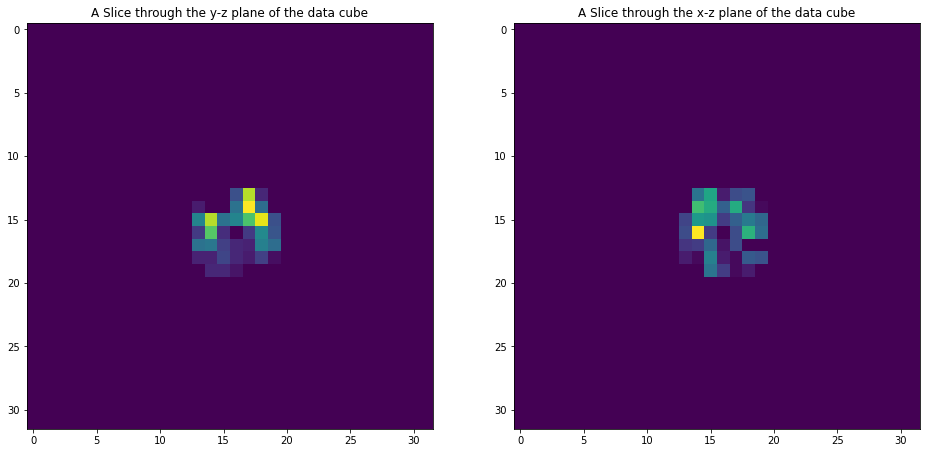

In [11]:
with h5.File(f"{chain_dir}/restart.h5_0",mode="r") as hf:
    data = hf['scalars/galaxy_data_3']
    #Plot data
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))
    ax1.set_title('A Slice through the y-z plane of the data cube')
    im1=ax1.imshow(data[16,:,:])

    ax2.set_title('A Slice through the x-z plane of the data cube')
    im2=ax2.imshow(data[:,16,:])

    plt.show()

As we have mask and selections we see that the data is only present in the center.

## Investigating MCMC files

MCMC files are indexed by the sample number $i_\mathrm{samp}$. Each file can be opened separately. Suppose we want to open the th mcmc file, then:

In [12]:
isamp=10 # sample number
fname_mcmc=f"{chain_dir}/mcmc_{isamp}.h5"
with h5.File(fname_mcmc, mode="r") as hf:
    # Do something
    print(hf)

<HDF5 file "mcmc_10.h5" (mode r)>


### Inspect the content of the mcmc files

In [13]:
with h5.File(fname_mcmc, mode="r") as hf:
    # Do something
    print(list(hf['scalars'].keys()))


['BORG_final_density', 'catalog_foreground_coefficient_0', 'catalog_foreground_coefficient_1', 'catalog_foreground_coefficient_10', 'catalog_foreground_coefficient_11', 'catalog_foreground_coefficient_12', 'catalog_foreground_coefficient_13', 'catalog_foreground_coefficient_14', 'catalog_foreground_coefficient_15', 'catalog_foreground_coefficient_2', 'catalog_foreground_coefficient_3', 'catalog_foreground_coefficient_4', 'catalog_foreground_coefficient_5', 'catalog_foreground_coefficient_6', 'catalog_foreground_coefficient_7', 'catalog_foreground_coefficient_8', 'catalog_foreground_coefficient_9', 'cosmology', 'galaxy_bias_0', 'galaxy_bias_1', 'galaxy_bias_10', 'galaxy_bias_11', 'galaxy_bias_12', 'galaxy_bias_13', 'galaxy_bias_14', 'galaxy_bias_15', 'galaxy_bias_2', 'galaxy_bias_3', 'galaxy_bias_4', 'galaxy_bias_5', 'galaxy_bias_6', 'galaxy_bias_7', 'galaxy_bias_8', 'galaxy_bias_9', 'galaxy_nmean_0', 'galaxy_nmean_1', 'galaxy_nmean_10', 'galaxy_nmean_11', 'galaxy_nmean_12', 'galaxy_nme

### Plotting density fields
We can for instance be interested in plotting inferred initial and final density samples.

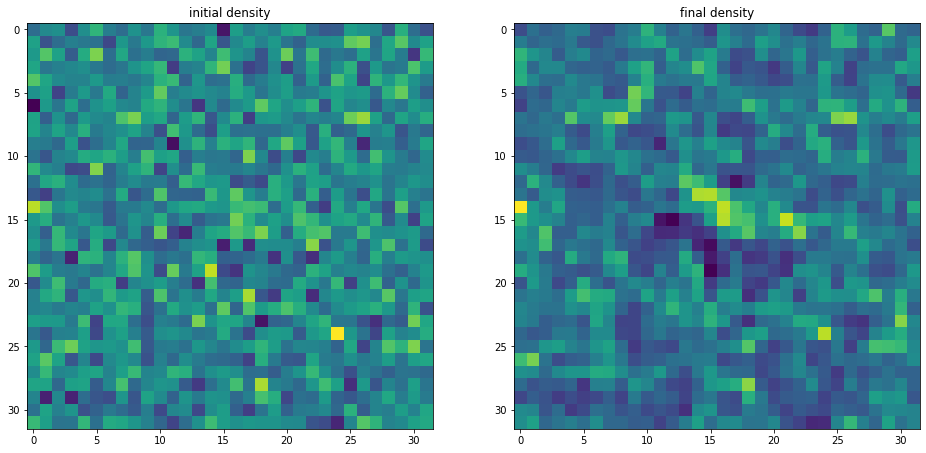

In [14]:
with h5.File(fname_mcmc, mode="r") as hf:

    delta_in=np.array(hf['scalars/s_field'])
    delta_fi=np.array(hf['scalars/BORG_final_density'])

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 8))
    ax1.set_title('initial density')
    im1=ax1.imshow(delta_in[16,:,:])

    ax2.set_title('final density')
    im2=ax2.imshow(delta_fi[16,:,:])

    plt.show()

We notice that no mask due to selection is visible there. That is because BORG provided a fair sample from the posterior distribution, which accounts for this mask while using the prior to fill the missing parts.

### Plotting the power-spectrum

The ARES repository provides some routines to analyse the BORG runs. A particularly useful routine calculates the posterior power-spectra of inferred initial density fields.

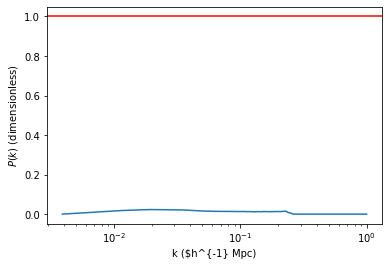

In [15]:
ss = aq.analysis.Analysis(chain_dir,LSS_framework='BORG')

# Indicate how many bins we want for the power spectrum.
# This number is sticky internally as it involves precomputing some quantities.
# Please keep it to a fixed number for each instance `ss`
# `unit=True` is important for BORG >= 2.0 as shat is stored dimensionless
opts=dict(Nbins=128,unit=True)

#You can choose the sample number
isamp=10
#
P_k,Pw,k_mode=ss.compute_power_shat_spectrum(isamp, **opts)

# Here we compute the bin centered position for each P(kmode)
k_mode_c = 0.5*(k_mode[1:]+k_mode[:-1])

plt.axhline(1.0,color='r')
plt.semilogx(k_mode_c,P_k)
plt.xlabel('k ($h^{-1} Mpc)')
plt.ylabel(r'$P(k)$ (dimensionless)')
plt.show()

The spectrum here-above is dimensionless as BORG works on variables prior to the convolution with primordial gravitational perturbations and primordial generation of density perturbations. If nothing bad happened and the cosmology in the ini file corresponds to the data, that spectrum should fluctuate around  `1`.

### Monitoring power-spectrum warm-up phase
Rather than looking just at individual posterior sample power-spectra we can follow the evolution of power-spectra across the chain. Suppose you want to monitor the first 1000 samples.

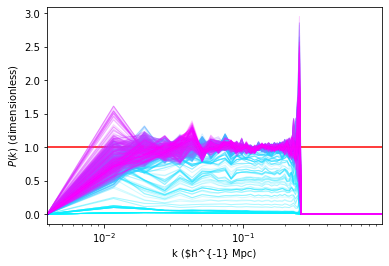

In [16]:
Nsamp=1000
PPs=[]
for isamp in np.arange(Nsamp):
    # All samples have the same second and third tuple element
    PPs.append(ss.compute_power_shat_spectrum(isamp, **opts)[0])

    

#plot power-spectra
color_idx = np.linspace(0, 1, Nsamp)
plt.axhline(1.0,color='r')
idx=0
for PP in PPs:
    plt.semilogx(k_mode_c,PP,alpha=0.2,color=plt.cm.cool(color_idx[idx]), lw=1)
    idx=idx+1
plt.xlim([min(k_mode_c),max(k_mode_c)])
plt.xlabel('k ($h^{-1} Mpc)')
plt.ylabel(r'$P(k)$ (dimensionless)')
plt.show()


Instead of looking at the power spectrum per mode we can look at the trace plot of the value for each mode. That allows to detect visually any oddity in the chain and observe the existence of a transition period. 

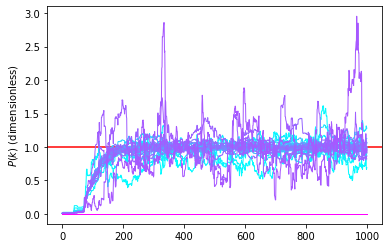

In [17]:
PPs_trace = np.array(PPs).transpose()
# We limit to the first 50 modes just for plotting purpose
color_idx = np.linspace(0, 1, len(PPs_trace[:50]))
plt.axhline(1.0,color='r')
idx=0
for i,PP in enumerate(PPs_trace[:50]):
    plt.plot(PP,alpha=1.0,color=plt.cm.cool(color_idx[i]), lw=1)
#plt.xlim([min(k_mode_c),max(k_mode_c)])
#plt.xlabel('k ($h^{-1} Mpc)')
plt.ylabel(r'$P(k)$ (dimensionless)')
plt.show()


### Exploring density field
The above chain shows a transitionary phase (often called burn-in), which corresponds to a fast transition from a low probability to a high probability state. It is generally advised to truncate this part of the chain for short chains as it removes part of the samples that are highly unlikely. One may then compute interesting summaries of the chain. A typical interesting one is the mean and standard deviation per voxel of the density. Formally that corresponds to doing it the following operations:
$$
\langle \delta_{i,j,k}\rangle = \int_\delta \text{d}\delta P(\delta) \delta_{i,j,k} \simeq \frac{1}{N_\text{MCMC}} \sum_{n} \delta^{(n)}_{i,j,k}
$$
with $n$ running over the elements of the chain after burnin and $N_\text{MCMC}$ the number of these elements. Here-below, we will compute this quantity and the standard deviation after truncating the first 200 samples which looks reasonable given the above trace plot of the power spectra.

In [18]:
# do_dev=True indicates to compute the standard deviation
# start=500 indicates to start computing at the sample 500
m=aq.utils.read_chain_avg_dev(chain_dir,['scalars.BORG_final_density'],do_dev=True,start=100)

  0%|          | 0/900 [00:00<?, ?it/s]

Now we need to represent this field. To make a change, and actually uses physical coordinates (comoving coordinates), we will pcolormesh instead of imshow (which does a number of transpose to the field by default).

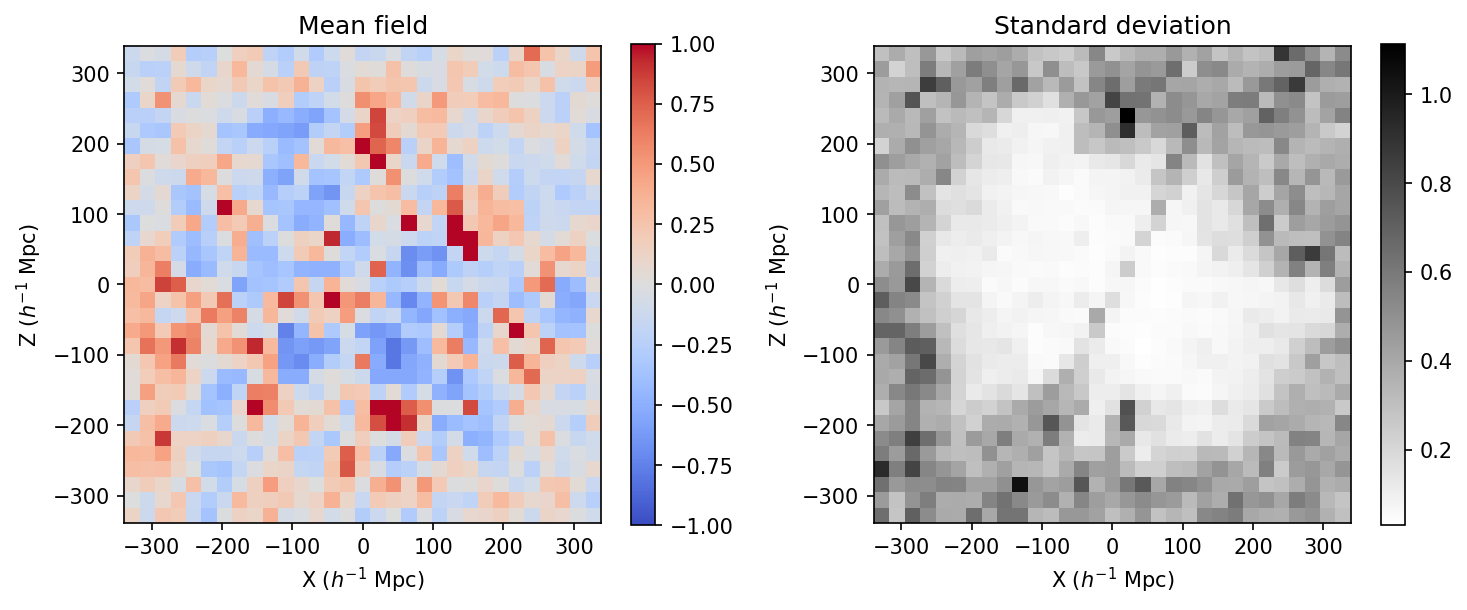

In [19]:
ix=np.linspace(-677.7/2,677.7/2,32)

# Note the peculiar indexing that is required
xm,ym,zm=np.meshgrid(ix,ix,ix,indexing='ij')

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 4),dpi=150)

ax1.set_title("Mean field")
mean_den=ax1.pcolormesh(xm[:,:,16],zm[:,16,:],m['scalars.BORG_final_density'][0][:,16,:],cmap=plt.cm.coolwarm,vmin=-1,vmax=1)
ax1.set_aspect('equal')
ax1.set_xlabel('X ($h^{-1}$ Mpc)')
ax1.set_ylabel('Z ($h^{-1}$ Mpc)')
plt.colorbar(mean_den,ax=ax1)

ax2.set_title("Standard deviation")
std_den=ax2.pcolormesh(xm[:,:,16],zm[:,16,:],m['scalars.BORG_final_density'][1][:,16,:],cmap=plt.cm.gray_r)
ax2.set_aspect('equal')
ax2.set_xlabel('X ($h^{-1}$ Mpc)')
ax2.set_ylabel('Z ($h^{-1}$ Mpc)')
plt.colorbar(std_den,ax=ax2)
plt.tight_layout()
plt.show()

In the above, we see that the standard deviation is varying quite a lot between different regions of the sky. That is expected given the selection that has been used in the model. The selection can be checked directly by looking at the field `scalars/galaxy_sel_window_0`  (and all the others depending on the number of catalogs) in the restart file.